# **1. Importing Library**

In [28]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# **2. Preparing Dataset**

In [29]:
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [30]:
import splitfolders 
splitfolders.ratio("/kaggle/input/agronify-dataset/DiseasedPlants/DiseasedPlants/Pertanian/Jagung", 
                   output="Jagung-data", 
                   seed=42, 
                   ratio=(.7, .2, .1), 
                   group_prefix=None) 


Copying files: 4787 files [00:09, 492.82 files/s] 


In [31]:
training_dir = os.path.join('Jagung-data', 'train')
testing_dir = os.path.join('Jagung-data', 'test')
validating_dir = os.path.join('Jagung-data', 'val')

# **3. Data Preprocessing**

In [32]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    shuffle=True,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    validating_dir,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

Found 3349 images belonging to 4 classes.
Found 955 images belonging to 4 classes.
Found 483 images belonging to 4 classes.


In [33]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)
class_count = len(class_names)

{'Corn__common_rust': 0, 'Corn__gray_leaf_spot': 1, 'Corn__healthy': 2, 'Corn__northern_leaf_blight': 3}
['Corn__common_rust', 'Corn__gray_leaf_spot', 'Corn__healthy', 'Corn__northern_leaf_blight']


# **4. Data Preview**

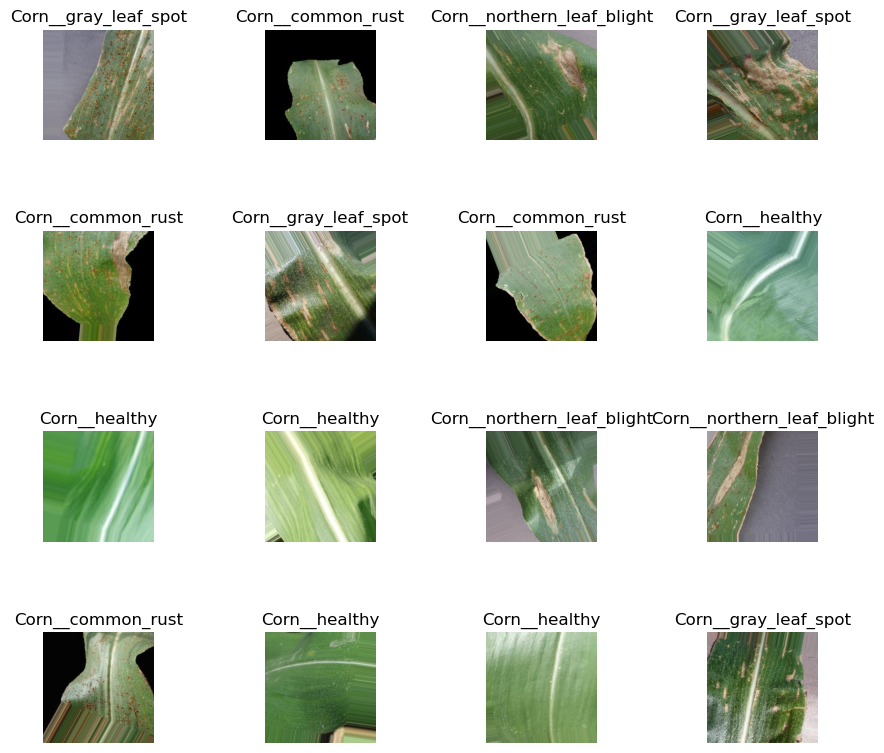

In [34]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()

# **5. Callbacks Function**

In [35]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, total_epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.total_epochs = total_epochs
        self.ask = True
        self.lowest_val_loss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.total_epochs:
            print('ask_epoch >= total_epochs, will train for', self.total_epochs, 'epochs', flush=True)
            self.ask = False
        if self.total_epochs == 1:
            self.ask = False
        else:
            print('Training will proceed until epoch', self.ask_epoch, 'then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        print('Loading model with weights from epoch', self.best_epoch)
        self.model.set_weights(self.best_weights)
        training_duration = time.time() - self.start_time
        hours = training_duration // 3600
        minutes = (training_duration - (hours * 3600)) // 60
        seconds = training_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg, flush=True)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss < self.lowest_val_loss:
            self.lowest_val_loss = val_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss of {val_loss:7.4f} is below the lowest loss, saving weights from epoch {str(epoch + 1):3s} as the best weights')
        else:
            print(f'\nValidation loss of {val_loss:7.4f} is above the lowest loss of {self.lowest_val_loss:7.4f}, keeping weights from epoch {str(self.best_epoch)} as the best weights')

        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\nEnter H to end training or an integer for the number of additional epochs to run then ask again')
                ans = input()

                if ans.lower() == 'h' or ans == '0':
                    print('You entered', ans, 'Training halted on epoch', epoch + 1, 'due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.total_epochs:
                        print('\nYou specified a maximum of', self.total_epochs, 'epochs. Cannot train for', self.ask_epoch, flush=True)
                    else:
                        print('You entered', ans, 'Training will continue to epoch', self.ask_epoch, flush=True)
                        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                        print(f'Current learning rate is {current_lr:7.5f}.')

# **6. Selecting Model**

In [36]:
tf.keras.backend.clear_session()
#del model

In [37]:
# IMAGE_CHANNEL = 3
# IMAGE_SIZE = 224

# model_name = 'MobileNetV3Small'
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)
# base_model = tf.keras.applications.MobileNetV3Small(input_shape=input_shape,
#                                                    include_top=False,
#                                                    weights='imagenet',
#                                                    pooling='max')

# base_model.trainable = True


# **7. Creating Architecture Model**

In [47]:
IMAGE_CHANNEL = 3
IMAGE_SIZE = 224
OUTPUT_SIZE = len(class_names)

#1
# model = Sequential([
#     Conv2D(72, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(32, (3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE)+(3,)),
#     Dense(128, activation='relu'),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dense(OUTPUT_SIZE, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
# ])

#2
model = Sequential([
    Conv2D(512, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL), padding='same', strides=(1,1)),
    MaxPooling2D(pool_size=(3, 3)),
    
    Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu', padding='same',strides=(1,1)),
    MaxPooling2D(2,2),
    
    Conv2D(32, (3,3), activation='relu', padding='same',strides=(1,1)),
    MaxPooling2D(2,2),
    Flatten(),
    
    Dense(16, activation='relu'),
    Dense(OUTPUT_SIZE, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 512)     14336     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 512)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 74, 74, 256)       1179904   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 37, 128)       295040    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 18, 18, 128)     

# **8. Training Model**

In [48]:
total_epochs = 50
ask_epoch = 49
ask_callback = LR_ASK(model, total_epochs, ask_epoch)
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4, verbose=2)
callbacks = [rlronp_callback, ask_callback]

# **9. Model Validation**

In [49]:
training_history = model.fit(train_generator,
                             epochs=total_epochs,
                             verbose=2,
                             callbacks=callbacks,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             initial_epoch=0)

Training will proceed until epoch 49 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/50

Validation loss of  1.0006 is below the lowest loss, saving weights from epoch 1   as the best weights
105/105 - 62s - loss: 1.0445 - accuracy: 0.4610 - val_loss: 1.0006 - val_accuracy: 0.4817 - lr: 0.0010 - 62s/epoch - 594ms/step
Epoch 2/50

Validation loss of  0.5930 is below the lowest loss, saving weights from epoch 2   as the best weights
105/105 - 60s - loss: 0.8066 - accuracy: 0.6112 - val_loss: 0.5930 - val_accuracy: 0.7361 - lr: 0.0010 - 60s/epoch - 573ms/step
Epoch 3/50

Validation loss of  0.4801 is below the lowest loss, saving weights from epoch 3   as the best weights
105/105 - 60s - loss: 0.5641 - accuracy: 0.7151 - val_loss: 0.4801 - val_accuracy: 0.7958 - lr: 0.0010 - 60s/epoch - 572ms/step
Epoch 4/50

Validation loss of  0.4610 is below the lowest loss, saving weights from epoch 4   as the best weig

KeyboardInterrupt: 

# **10. Model Evaluation**

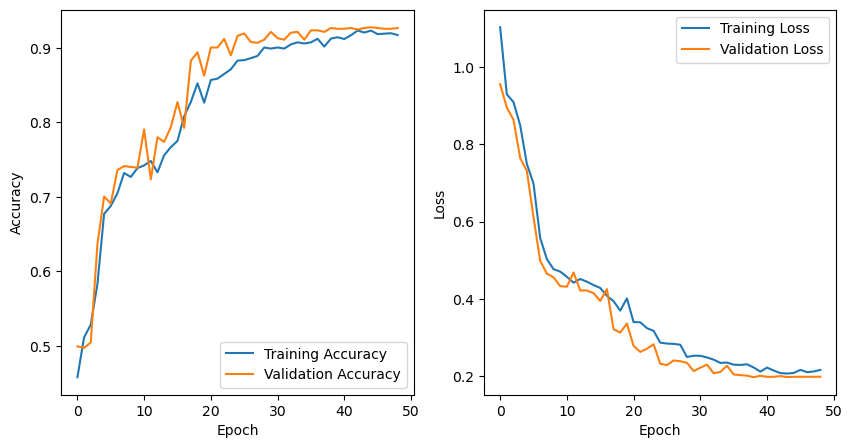

In [44]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [45]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

16/16 [==============================] - 2s 145ms/step - loss: 0.1769 - accuracy: 0.9379
Test loss: 0.17688919603824615 / Test accuracy: 0.9378882050514221


# **11. Prediction Test**

# **12. Save Model**

In [46]:
model.save('jagungDeepLearningV2.h5')